In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Parameters

In [143]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
pickles_dir = f'{engram_dir}pickles/pnet_cgram_shuffle_denoising/'
file_prefix = 'pearsonr'

In [144]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Load Results

In [145]:
np.unique(df['popln_timestep'])

array([0, 1, 2, 3, 4])

In [146]:
max_scores = {}
for bg in ['pinkNoise', 'AudScene', 'Babble8Spkr']:
    max_scores[bg] = {}
    for snr in [-9., -6., -3.,  0.,  3.]:
        max_scores[bg][snr] = {}
results = {
    'popln_shuffle': [], 'popln_timestep': [],
    'popln_sim': [], 'popln_layer': [], 'valid_score': [],
    'bg': [], 'snr': [], 'is_max': []}

# Load each pickle result
for pickle_file in os.listdir(pickles_dir):
    if not pickle_file.startswith(file_prefix): continue
    noise_info = pickle_file.split('_')
    noise_bg = noise_info[1]
    noise_snr = float(noise_info[2][3:-2])
    with open(f'{pickles_dir}{pickle_file}', 'rb') as f:
        _results = pickle.load(f)
    for key in _results.keys():
        results[key].extend(_results[key])
    results['bg'].extend([noise_bg]*len(_results[key]))
    results['snr'].extend([noise_snr]*len(_results[key]))
    
    for t in [0, 1, 2, 3, 4]:
        t_idxs = np.array(_results['popln_timestep']) == t
        valid_score = np.array(_results['valid_score'])
        max_score = np.max(valid_score[t_idxs])
        max_scores[noise_bg][noise_snr][t] = max_score
    is_max = []
    for v, t in zip(_results['valid_score'], _results['popln_timestep']):
        is_max.append(v == max_scores[noise_bg][noise_snr][t])
    results['is_max'].extend(is_max)
for key in results.keys():
    results[key] = np.array(results[key])

# Calculate extra measures

In [147]:
norm_popln_sim = results['popln_sim'].copy()
for l in np.unique(results['popln_layer']):
    for bg in np.unique(results['bg']):
        for snr in np.unique(results['snr']):
            idxs = results['popln_layer'] == l
            #idxs = np.logical_and(results['popln_timestep'] == 0, idxs)
            idxs = np.logical_and(results['bg'] == bg, idxs)
            idxs = np.logical_and(results['snr'] == snr, idxs)
            mean_shuff = np.mean(results['popln_shuffle'][idxs])
            norm_popln_sim[idxs] /= mean_shuff
results['norm_popln_sim'] = norm_popln_sim

In [148]:
df = pd.DataFrame(results)

# Across Timesteps

In [149]:
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']

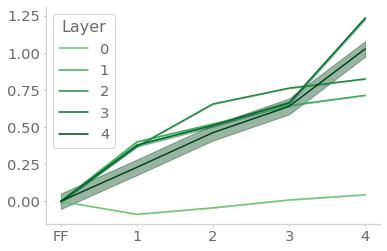

In [150]:
from scipy.stats import sem
import matplotlib.cm as cm

colors = cm.get_cmap('Greens')(np.linspace(0.5, 1., len(layers)))
ts = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
for layer_idx, layer in enumerate(layers):
    layer_means = []
    layer_sems = []
    for t in ts:
        vals = df[(df['popln_layer']==layer) & (df['popln_timestep']==t)]
        vals = vals['norm_popln_sim']
        if t == 0:
            vals_baseline = np.mean(vals)
        vals -= vals_baseline
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    ax.plot(
        ts, layer_means,
        label=layer_idx, color=colors[layer_idx]
        )
    ax.fill_between(
        ts, layer_means-layer_sems, layer_means+layer_sems,
        color=colors[layer_idx], alpha=0.4
        )
plt.legend(title='Layer')
plt.xticks([0,1,2,3,4], ['FF', '1', '2', '3', '4'])
plt.savefig('../figures/corrs.svg', dpi=300)
plt.show()


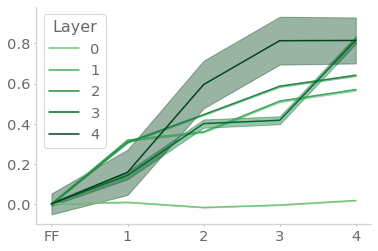

In [151]:
from scipy.stats import sem
import matplotlib.cm as cm

new_df = df.copy()
new_df = new_df[new_df['is_max']==True]
colors = cm.get_cmap('Greens')(np.linspace(0.5, 1., len(layers)))
ts = [0, 1, 2, 3, 4]
fig, ax = plt.subplots()
for layer_idx, layer in enumerate(layers):
    layer_means = []
    layer_sems = []
    for t in ts:
        vals = new_df[(new_df['popln_layer']==layer) & (new_df['popln_timestep']==t)]
        vals = vals['norm_popln_sim']
        if t == 0:
            vals_baseline = np.mean(vals)
        vals -= vals_baseline
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    ax.plot(
        ts, layer_means,
        label=layer_idx, color=colors[layer_idx]
        )
    ax.fill_between(
        ts, layer_means-layer_sems, layer_means+layer_sems,
        color=colors[layer_idx], alpha=0.4
        )
plt.legend(title='Layer')
plt.xticks([0,1,2,3,4], ['FF', '1', '2', '3', '4'])
plt.savefig('../figures/corrs.svg', dpi=300)
plt.show()


# By noise type

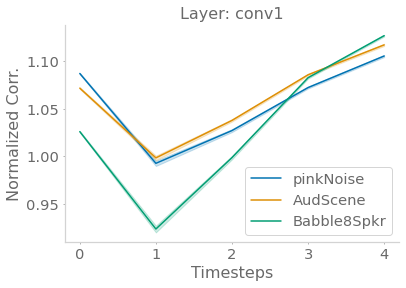

In [152]:
fig, ax = plt.subplots()
l = 'conv1'
y = 'norm_popln_sim'
ff_subtract = False

for bg in ['pinkNoise', 'AudScene', 'Babble8Spkr']:
    new_df = df[(df['popln_layer']==l) & (df['bg']==bg)]
    if ff_subtract:
        new_df['popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['popln_sim'])
        new_df['norm_popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['norm_popln_sim'])
    sns.lineplot(
        x='popln_timestep', y=y,
        data=new_df, ax=ax, label=bg
        )
ylabel = 'Normalized Corr.'
if ff_subtract:
    ylabel += '\n(Difference from FF)'
plt.ylabel(ylabel)
plt.xlabel('Timesteps')
plt.title(f'Layer: {l}')
plt.legend()

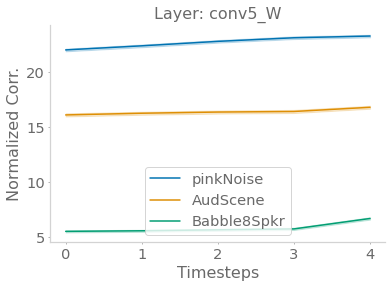

In [153]:
fig, ax = plt.subplots()
l = 'conv5_W'
y = 'norm_popln_sim'
ff_subtract = False
for bg in ['pinkNoise', 'AudScene', 'Babble8Spkr']:
    new_df = df[(df['popln_layer']==l) & (df['bg']==bg)]
    if ff_subtract:
        new_df['popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['popln_sim'])
        new_df['norm_popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['norm_popln_sim'])
    sns.lineplot(
        x='popln_timestep', y=y,
        data=new_df, ax=ax, label=bg
        )
ylabel = 'Normalized Corr.'
if ff_subtract:
    ylabel += '\n(Difference from FF)'
plt.ylabel(ylabel)
plt.xlabel('Timesteps')
plt.title(f'Layer: {l}')
plt.legend()

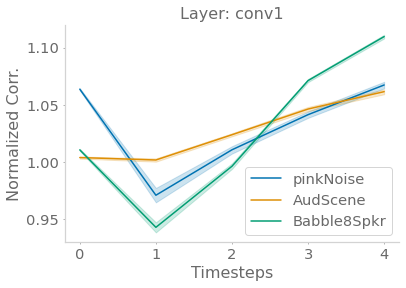

In [154]:
fig, ax = plt.subplots()
l = 'conv1'
y = 'norm_popln_sim'
ff_subtract = False

for bg in ['pinkNoise', 'AudScene', 'Babble8Spkr']:
    new_df = df[(df['popln_layer']==l) & (df['bg']==bg) & (df['snr']==-9.)]
    if ff_subtract:
        new_df['popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['popln_sim'])
        new_df['norm_popln_sim'] -= np.mean(new_df[new_df['popln_timestep']==0]['norm_popln_sim'])
    sns.lineplot(
        x='popln_timestep', y=y,
        data=new_df, ax=ax, label=bg
        )
ylabel = 'Normalized Corr.'
if ff_subtract:
    ylabel += '\n(Difference from FF)'
plt.ylabel(ylabel)
plt.xlabel('Timesteps')
plt.title(f'Layer: {l}')
plt.legend()

# By SNR

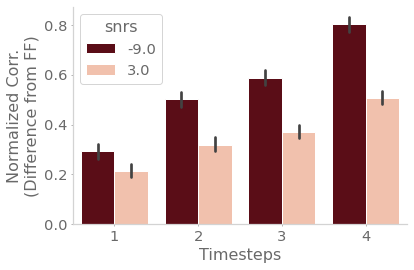

In [130]:
fig, ax = plt.subplots()
import matplotlib.cm as cm
colors = cm.get_cmap('Reds_r')(np.linspace(0., 0.75, 5))

val_string = 'norm_popln_sim'
data = {
    'snrs': [], 'layers': [],
    'timesteps': [], 'vals': []}
for snr in [-9., 3.]:
    for l in layers:
        new_df = df[(df['popln_layer'] == l) & (df['snr']==snr)]
        ff_baseline = np.mean(new_df[new_df['popln_timestep']==0][val_string])
        vals = (new_df[val_string] - ff_baseline).tolist()
        data['snrs'].extend([snr]*len(vals))
        data['layers'].extend([l]*len(vals))
        data['timesteps'].extend(new_df['popln_timestep'].tolist())
        data['vals'].extend(vals)

new_df = pd.DataFrame(data)
g = sns.barplot(
    x='timesteps', y='vals',
    data=new_df[new_df['timesteps'] != 0],
    hue='snrs', ax=ax, palette=[colors[0], colors[-1]]
    )
#g.legend_.remove()
ax.set_ylabel('Normalized Corr.\n(Difference from FF)')
ax.set_xlabel('Timesteps')
plt.savefig('corr_snr.svg', dpi=300)

# Across Layers

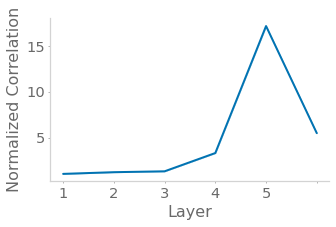

In [102]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    x='popln_layer', y='norm_popln_sim',
    data=df, color='C0', linewidth=2, ax=ax
    )
plt.ylabel('Normalized Correlation')
plt.xlabel('Layer')
ax.set_xticklabels([1,2,3,4,5])
plt.savefig('corr_layers.svg', dpi=300)